# Homework 6

## Imports and Utilities
**Note**: these imports and functions are available in catsoop. You do not need to copy them in.

In [1]:

from typing import (Callable, Iterable, List, Sequence, Tuple, Dict, Optional,
                    Any, Union)

from abc import abstractmethod
import collections
import itertools
import functools
import random

import numpy as np

########## Graph-Search-Related Utilities and Class Definitions ##########

State = Any
Action = Any

StateSeq = List[State]
ActionSeq = List[State]
CostSeq = RewardSeq = List[float]


class Problem(object):
  """The abstract base class for either a path cost problem or a reward problem."""

  def __init__(self, initial: State):
    self.initial = initial

  @abstractmethod
  def actions(self, state: State) -> Iterable[Action]:
    """Returns the allowed actions in a given state.

    The result would typically be a list. But if there are many actions,
    consider yielding them one at a time in an iterator,
    rather than building them all at once.
    """
    ...

  @abstractmethod
  def step(self, state: State, action: Action) -> State:
    """Returns the next state when executing a given action in a given state.

    The action must be one of self.actions(state).
    """
    ...


class PathCostProblem(Problem):
  """An abstract class for a path cost problem, based on AIMA.

  To formalize a path cost problem, you should subclass from this and implement
  the abstract methods.
  Then you will create instances of your subclass and solve them with the
  various search functions.
  """

  @abstractmethod
  def goal_test(self, state: State) -> bool:
    """Checks if the state is a goal."""
    ...

  @abstractmethod
  def step_cost(self, state1: State, action: Action, state2: State) -> float:
    """Returns the cost incurred at state2 from state1 via action."""
    ...

  def h(self, state: State) -> float:
    """Returns the heuristic value, a lower bound on the distance to goal."""
    return 0


class RewardProblem(Problem):
  """An abstract class for a finite-horizon reward problem, based on AIMA.

  To formalize a reward problem, you should subclass from this and implement
  the abstract methods.
  Then you will create instances of your subclass and solve them with the
  various search functions.
  """

  def __init__(self, initial: State, horizon: int):
    self.initial = initial
    self.horizon = horizon

  @abstractmethod
  def reward(self, state1: State, action: Action, state2: State) -> float:
    """Returns the reward given at state2 from state1 via action.

    A reward at each step must be no greater than `self.rmax`.
    """
    ...

  @property
  @abstractmethod
  def rmax(self) -> float:
    """Returns the maximum reward per step."""
    ...





## Best-first Search


### Utilities


**Note**: these imports and functions are available in catsoop. You do not need to copy them in.

In [2]:


class GridProblem(PathCostProblem):
  """A grid problem."""

  def __init__(self, initial=(0, 0), goal=(4, 4)):
    super().__init__(initial)
    self.goal = goal
    self.all_grid_actions = ["up", "down", "left", "right"]
    self.grid_act_to_delta = {
        "up": (-1, 0),
        "down": (1, 0),
        "left": (0, -1),
        "right": (0, 1)
    }
    # Somewhat unusual cost structure, depends on s', which is determined by s,a
    self.grid_arrival_costs = np.array(
        [
            [1, 1, 8, 1, 1],
            [1, 8, 1, 1, 1],
            [1, 8, 1, 1, 1],
            [1, 1, 1, 8, 1],
            [1, 1, 2, 1, 1],
        ],
        dtype=int,
    )

  def actions(self, state):
    (r, c) = state
    actions = []
    for act in self.all_grid_actions:
      dr, dc = self.grid_act_to_delta[act]
      new_r, new_c = r + dr, c + dc
      # Check if in bounds
      if (0 <= new_r < self.grid_arrival_costs.shape[0] and
          0 <= new_c < self.grid_arrival_costs.shape[1]):
        actions.append(act)
    return actions

  def step(self, state, action):
    (r, c) = state
    dr, dc = self.grid_act_to_delta[action]
    return (r + dr, c + dc)

  def goal_test(self, state):
    return state == self.goal

  def step_cost(self, state1, action, state2):
    return self.grid_arrival_costs[state2]

  def h(self, state):
    """Manhattan distance."""
    return abs(state[0] - self.goal[0]) + abs(state[1] - self.goal[1])


import contextlib


@contextlib.contextmanager
def count_method_calls(problem: Problem, *meths: str):
  """Track number of method invocations to a problem.

  Args:
    problem: an instance of a Problem.
    meths: a sequence of names for the methods to track call counts for.

  Example:
    >>> problem = GridProblem()
    >>> with count_method_calls(problem, "step") as counters:
    ...   problem.step((0, 0), "down")
    ...   problem.step((1, 1), "up")
    ...   assert counters["step"][((0, 0), "down")] == counters["step"][((1, 1), "up")]  == 1
    ...   assert counters["step"]["total"] == 2
  """
  counters = {meth: collections.Counter() for meth in meths}

  orig_problem_methods = {meth: getattr(problem, meth) for meth in meths}

  def meth_helper(attr, *args):
    counters[attr][args] += 1
    counters[attr]["total"] += 1
    return orig_problem_methods[attr](*args)

  for meth in meths:
    orig_problem_methods[meth] = getattr(problem, meth)
    setattr(problem, meth, functools.partial(meth_helper, meth))

  try:
    yield counters
  finally:
    for meth in meths:
      setattr(problem, meth, orig_problem_methods[meth])


**Note**: these imports and functions are available in catsoop. You do not need to copy them in.

In [3]:

import heapq as hq  # Can use this as a priority queue

# A useful data structure for best-first search
Node = collections.namedtuple("Node",
                              ["state", "parent", "action", "cost", "g"])


class SearchFailed(ValueError):
  """Raise this exception whenever a search must fail."""
  pass

### Question
Complete an implementation of the best-first search, encompassing A*, GBFS, or UCS.
      You can assume any heuristics are consistent.
      You should follow the psuedocode given in lecture closely.
      In particular, your implementation should prune redundant paths by remembering the reached states.

For reference, our solution is **55** line(s) of code.

In [63]:
def run_best_first_search(
    problem: PathCostProblem,
    get_priority: Callable[[Node], float],
    step_budget: int = 1000) -> Tuple[StateSeq, ActionSeq, CostSeq, int]:
  """A generic heuristic search implementation.

  Depending on `get_priority`, can implement A*, GBFS, or UCS.

  The `get_priority` function here should determine the order
  in which nodes are expanded. For example, if you want to
  use path cost as part of this determination, then the
  path cost (node.g) should appear inside of get_priority,
  rather than in this implementation of `run_best_first_search`.

  Important: for determinism (and to make sure our tests pass),
  please break ties using the state itself. For example,
  if you would've otherwise sorted by `get_priority(node)`, you
  should now sort by `(get_priority(node), node.state)`.

  Args:
    problem: a path cost problem.
    get_priority: a callable taking in a search Node and returns the priority
    step_budget: maximum number of `problem.step` before giving up.

  Returns:
    state_sequence: A list of states.
    action_sequence: A list of actions.
    cost_sequence: A list of costs.
    num_steps: number of taken `problem.step`s. Must be less than or equal to `step_budget`.

  Raises:
    error: SearchFailed, if no plan is found.
  """
  num_steps = 0
  n = Node(state=problem.initial, parent=None, action=None, cost=0, g=0)
  frontier = []
  hq.heappush(frontier, (get_priority(n), n.state, n))
  reached = {problem.initial:n}
  while num_steps < step_budget:
    with count_method_calls(problem, "step", "actions") as counters:
      n = hq.heappop(frontier)[2]
      state = n.state
      if problem.goal_test(state):
        state_sequence, action_sequence, cost_sequence = [], [], []
        curr = reached[state]
        while curr.parent is not None:
          state_sequence.append(curr.state)
          action_sequence.append(curr.action)
          cost_sequence.append(curr.cost - curr.parent.cost)
          curr = curr.parent
        state_sequence.append(curr.state)

        state_sequence.reverse()
        action_sequence.reverse()
        cost_sequence.reverse()
        return state_sequence, action_sequence, cost_sequence, num_steps

      actions = problem.actions(state)
      for a in actions:
        s_prime = problem.step(state,a)
        path_cost = n.cost + problem.step_cost(state, a, s_prime)
        if not s_prime in reached or path_cost < reached[s_prime].cost:
          n_prime = Node(state=s_prime, parent = n, action = a, cost = path_cost, g=path_cost)
          reached[s_prime] = n_prime
          hq.heappush(frontier, (get_priority(n_prime), n_prime.state, n_prime))
    num_steps += counters["step"]["total"]
  raise SearchFailed




### Tests

In [64]:
# We will test this implementation more thoroughly with the
# specific heuristic search algorithms that follow
grid_problem = GridProblem()
get_priority_fn = lambda node: 0
result = run_best_first_search(grid_problem, get_priority_fn)
assert len(result) == 4


def best_first_search_test2():
  # We will test this implementation more thoroughly with the
  # specific heuristic search algorithms that follow
  grid_problem = GridProblem()
  get_priority_fn = lambda node: 0
  with count_method_calls(grid_problem, "step", "actions") as counters:
    state_sequence, action_sequence, cost_sequence, num_steps = run_best_first_search(
        grid_problem, get_priority_fn)
    assert (counters["step"].pop("total") == num_steps
           ), "Incorrect report of number of `problem.step`s"

  # Textbook implementation
  try:
    assert state_sequence == [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4),
                              (2, 4), (3, 4), (4, 4)]
    assert action_sequence == [
        'right', 'right', 'right', 'right', 'down', 'down', 'down', 'down'
    ]
    assert cost_sequence == [1.0, 8.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  # Alternative implementation that tracks best-cost-to-nodes
  except AssertionError:
    assert state_sequence == [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2),
                              (4, 2), (4, 3), (4, 4)]
    assert action_sequence == [
        'down', 'down', 'down', 'right', 'right', 'down', 'right', 'right'
    ]
    assert cost_sequence == [1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0]
  assert num_steps <= 252

best_first_search_test2()


def best_first_search_test3():
  """If your results do not match the expected ones, make sure that you are
  tie-breaking as described in the docstring for `run_best_first_search`."""
  grid_problem = GridProblem()
  get_priority_fn = lambda node: node.g
  with count_method_calls(grid_problem, "step", "actions") as counters:
    state_sequence, action_sequence, cost_sequence, num_steps = run_best_first_search(
        grid_problem, get_priority_fn)
    assert (counters["step"].pop("total") == num_steps
           ), "Incorrect report of number of `problem.step`s"
  assert state_sequence == [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2),
                            (4, 2), (4, 3), (4, 4)]
  assert action_sequence == [
      'down', 'down', 'down', 'right', 'right', 'down', 'right', 'right'
  ]
  assert cost_sequence == [1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0]
  assert num_steps <= 70

best_first_search_test3()

print('Tests passed.')

Tests passed.


## Uniform Cost Search


### Question
Use your implementation of `run_best_first_search` to implement uniform cost search.

For reference, our solution is **3** line(s) of code.

In addition to all of the utilities defined at the top of the colab notebook, the following functions are available in this question environment: `run_best_first_search`. You may not need to use all of them.

In [65]:
def run_uniform_cost_search(problem: PathCostProblem, step_budget: int = 1000):
  """Uniform-cost search.

  Use your implementation of `run_best_first_search`.
  """
  get_priority_fn = lambda node: node.cost
  return run_best_first_search(problem, get_priority_fn, step_budget)

### Tests

In [66]:
def ucs_test1():
  # If your results do not match the expected ones, make sure that you are tiebreaking
  # as described in the docstring for `run_best_first_search`.
  grid_problem = GridProblem()
  state_sequence, action_sequence, cost_sequence, num_steps = run_uniform_cost_search(
      grid_problem)
  assert state_sequence == [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2),
                            (4, 2), (4, 3), (4, 4)]
  assert action_sequence == [
      'down', 'down', 'down', 'right', 'right', 'down', 'right', 'right'
  ]
  assert cost_sequence == [1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0]
  assert num_steps <= 70

ucs_test1()

print('Tests passed.')

Tests passed.


## A* Search


### Question
Use your implementation of `run_best_first_search` to implement A* search.

For reference, our solution is **3** line(s) of code.

In addition to all of the utilities defined at the top of the colab notebook, the following functions are available in this question environment: `run_best_first_search`. You may not need to use all of them.

In [67]:
def run_astar_search(problem: PathCostProblem, step_budget: int = 1000):
  """A* search.

  Use your implementation of `run_best_first_search`.
  """
  get_priority_fn = lambda node: node.g + problem.h(node.state)
  return run_best_first_search(problem, get_priority_fn, step_budget)

### Tests

In [68]:
def astar_test1():
  """If your results do not match the expected ones, make sure that you are tiebreaking
  as described in the docstring for `run_best_first_search`."""
  grid_problem = GridProblem()
  state_sequence, action_sequence, cost_sequence, num_steps = run_astar_search(
      grid_problem)
  assert state_sequence == [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2),
                            (4, 2), (4, 3), (4, 4)]
  assert action_sequence == [
      'down', 'down', 'down', 'right', 'right', 'down', 'right', 'right'
  ]
  assert cost_sequence == [1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0]
  assert num_steps <= 36

astar_test1()

print('Tests passed.')

Tests passed.


## Greedy Best-First Search


### Question
Use your implementation of `run_best_first_search` to implement GBFS.

For reference, our solution is **3** line(s) of code.

In addition to all of the utilities defined at the top of the colab notebook, the following functions are available in this question environment: `run_best_first_search`. You may not need to use all of them.

In [69]:
def run_greedy_best_first_search(problem: PathCostProblem,
                                 step_budget: int = 1000):
  """GBFS.

  Use your implementation of `run_best_first_search`.
  """
  get_priority_fn = lambda node:  problem.h(node.state)
  return run_best_first_search(problem, get_priority_fn, step_budget)

### Tests

In [70]:
def gbfs_test1():
  """If your results do not match the expected ones, make sure that you are tiebreaking
  as described in the docstring for `run_best_first_search`."""
  problem = GridProblem()
  state_sequence, action_sequence, cost_sequence, num_steps = run_greedy_best_first_search(
      problem)
  assert state_sequence == [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4),
                            (2, 4), (3, 4), (4, 4)]
  assert action_sequence == [
      'right', 'right', 'right', 'right', 'down', 'down', 'down', 'down'
  ]
  assert abs(num_steps - 22) <= 1

gbfs_test1()

print('Tests passed.')

Tests passed.


## Visualize Reward Fields


### Utilities

The Fractal Problem and different reward fields.
          You shoud read the code below to get rough idea what each reward field looks like.

**Note**: these imports and functions are available in catsoop. You do not need to copy them in.

In [71]:

FractalProblemState = collections.namedtuple("FractalProblemState",
                                             ["x", "y", "t"])


class FractalProblem(RewardProblem):
  """A base class for "fractal problem".

  Briefly, a fractal problem is as follows:
    - The state space is the entire 2D Euclidean space
    - The initial state is (0, 0)
    - At each step $t$ the agent is allowed to move along one of the directions of size
      $$step_scale^{-t}$$.
    - At each step the agent receives a scalar reward based on a reward field.
  """

  def __init__(self,
               action_directions="8-neighbors",
               step_scale=0.5,
               horizon=6):
    """A base constructor for a fractal problem.

    Args:
      action_directions: allowed directions to move at each step.
      step_scale: each step length is scaled down by this amount.
    """
    super().__init__(FractalProblemState(0, 0, 1), horizon)
    if action_directions == "8-neighbors":
      self.action_directions = [
          (x, y)
          for x, y in itertools.product([-1, 0, 1], [-1, 0, 1])
          if (x, y) != (0, 0)
      ]
    elif action_directions == "4-neighbors":
      self.action_directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    else:
      self.action_directions = action_directions
    self.step_scale = step_scale
    self.field_of_view = self._compute_field_of_view()

  def _compute_field_of_view(self,
                             precision: float = 1.) -> Tuple[Tuple[float]]:
    """Computes a minimum rectangle that encloses all reachable states within horizon.

    Args:
      precision: the returned rectangle will have vertices that are integer
        multiples of `precision`. Defaults to 1., which means that the rectangle
        has integral vertices.

    Returns:
      the lower-left and upper-right vertices that represents the rectangle.
    """
    extent = sum([self.step_scale**(t + 1) for t in range(self.horizon)])
    dir_extent = np.array(self.action_directions) * extent
    return (
        tuple(np.floor(np.min(dir_extent, axis=0) / precision) * precision),
        tuple(np.ceil(np.max(dir_extent, axis=0) / precision) * precision),
    )

  @property
  def field_of_view_size(self):
    return (self.field_of_view[1][0] - self.field_of_view[0][0],
            self.field_of_view[1][1] - self.field_of_view[0][1])

  def actions(self, state):
    scale = self.step_scale**state.t
    return [(x * scale, y * scale) for x, y in self.action_directions]

  def step(self, state, action):
    ax, ay = action
    return FractalProblemState(state.x + ax, state.y + ay, state.t + 1)

  def reward(self, state, action, next_state):
    coord = np.array([next_state.x, next_state.y])
    return self.reward_field(coord).item()

  def reward_field(self, coords: np.ndarray):
    """The reward(s) at `coords`. Handle a batch of coordinates for efficiency of plotting.

    Subclass must override to provide a meaningful reward field.

    Args:
      coords: an array with shape (2,) or (...batch, 2) denoting the coordinate(s)
        to compute the reward field.

    Returns:
      A scalar or an array of shape (...batch,)
    """
    return np.zeros(coords.shape[:-1])

  @property
  def rmax(self):
    return 1.

  def visualize_reward_field(self,
                             fov: Tuple[Tuple[float]] = None,
                             resolution=(1000, 1000),
                             show=False):
    """Visualize a reward field.

    Args:
      fov: an optional field of view. If None, use self.field_of_view.
      resolution: number of pixels (w, h) to discretize the field of view.
      show: whether to display the plot immediately.
    """
    import matplotlib.pyplot as plt
    if fov is None:
      fov = self.field_of_view
    plt.xlim(fov[0][0], fov[1][0])
    plt.ylim(fov[0][1], fov[1][1])
    coords = np.dstack(
        np.meshgrid(
            np.linspace(fov[0][0], fov[1][0], resolution[0]),
            np.linspace(fov[0][1], fov[1][1], resolution[1]),
        )).reshape(-1, 2)
    vals = self.reward_field(coords).reshape(resolution)
    plt.imshow(vals,
               origin="lower",
               extent=(fov[0][0], fov[1][0], fov[0][1], fov[1][1]))
    plt.colorbar()
    if show:
      plt.show()
    return self

  def visualize_plan(self,
                     state_sequence: StateSeq,
                     fov: Tuple[Tuple[float]] = None,
                     show=False,
                     **arrow_kwargs):
    """Visualize a plan on the reward field.

    Visualizes a plan on top of the reward field.
    Usually, one calls `visualize_reward_field` first to draw the reward
    field in the back.
    One then chain multiple `visualize_plan` calls, and pass `show=True` to the
    last call to visualize multiple plans on the reward field.

    Args:
      state_sequence: A sequence state moving in the fractal problem.
      fov: an optional field of view. If None, use self.field_of_view.
      arrow_kwargs: passed to `plt.arrow`.
      show: whether to display the plot immediately.
    """
    import matplotlib.pyplot as plt
    if fov is None:
      fov = self.field_of_view
    plt.xlim(fov[0][0], fov[1][0])
    plt.ylim(fov[0][1], fov[1][1])
    for s1, s2 in zip(state_sequence[:-1], state_sequence[1:]):
      x1, y1, d = s1
      x2, y2, _ = s2
      dx, dy = x2 - x1, y2 - y1
      plt.arrow(x1,
                y1,
                dx,
                dy,
                length_includes_head=True,
                width=0.01 / d**0.5,
                fill=True,
                **arrow_kwargs)
    if show:
      plt.show()
    return self


from scipy.stats import multivariate_normal


class GradientRewardFieldProblem(FractalProblem):
  """A fractal problem with a gradient reward field by adding multiple (scaled)
  gaussian distributions.
  """

  def __init__(self,
               locs: Sequence[Tuple[int, int]] = ((0, 0),),
               covs: Union[float, Sequence[Union[float, np.ndarray]]] = 0.1,
               strengths: Union[float, Sequence[float]] = 1.,
               **kwargs):
    """A reward field with a mixture of guassian gradients.

    Args:
      locs: the centers of the gaussians
      covs: a scalar, a sequence of scalars, or a sequence of matrices
        for the covariances of the gaussians.
      strenghts: a scalar or a sequence of scalars for the scalaring factors
        for each guassian.
    """
    super().__init__(**kwargs)
    self.locs = locs
    if np.isscalar(covs):
      covs = [covs] * len(self.locs)
    covs = [np.eye(2) * cov if np.isscalar(cov) else cov for cov in covs]
    self.covs = covs
    if np.isscalar(strengths):
      strengths = [strengths] * len(self.locs)
    self.strengths = strengths

  def reward_field(self, coords):
    return sum([
        multivariate_normal.pdf(coords, mean=loc, cov=cov) * strength
        for loc, cov, strength in zip(self.locs, self.covs, self.strengths)
    ])


class NoisyRewardFieldProblem(FractalProblem):
  """A fractal problem with a reward field sampled from iid Beta distributions
  in a discretized grid.
  """

  def __init__(self, seed=0, bin_size=5e-2, beta_params=(1., 2.), **kwargs):
    super().__init__(**kwargs)
    # Compute number of bins required for the field of view
    self.nbins = tuple(int(s / bin_size) for s in self.field_of_view_size)
    # Initialize the random rewards within the field of view
    rng_state = np.random.RandomState(seed)
    self.random_locs = rng_state.beta(*beta_params, size=self.nbins)
    self.random_locs = np.pad(self.random_locs, [(1, 1), (1, 1)],
                              constant_values=0.)

  def reward_field(self, coords):
    binX, binY = tuple(
        np.digitize(
            coords[..., i],
            np.linspace(self.field_of_view[0][i], self.field_of_view[1][i],
                        self.nbins[i] + 1)) for i in range(2))
    return self.random_locs[binX, binY]


def get_fractal_problems() -> Dict[str, FractalProblem]:
  """Three fractal problems with reward fields.

  DO NOT CHANGE THIS FUNCTION --- it exists to protect you from accidentally
  changing the problems.
  """
  return {
      "reward-field-1":
          GradientRewardFieldProblem(locs=[(-1, -1), (-1, 1), (1, -1), (1, 1)],
                                     covs=[.3, .3, .3, .3],
                                     strengths=[1.5, 1.5, 1.5, 1.5]),
      "reward-field-2":
          GradientRewardFieldProblem(locs=[(-1, -1), (-1, 1), (1, -1), (1, 1)],
                                     covs=[.25, .25, .25, .2],
                                     strengths=[0.7, 0.7, 0.7, 0.8]),
      "reward-field-3":
          NoisyRewardFieldProblem(seed=42, bin_size=5e-2,
                                  beta_params=(0.2, 2.)),
  }

### Question
We have defined for you three fractal problems in `get_fractal_problems()`.
          Below you can visualize the reward fields corresponding to these problems.
          We have also provided you with code in the Colab notebook to recreate these visualizations.
          You are encouraged to inspect the relevant class definitions for these problems to understand them better.
          **You do not need to submit any code for this subsection.**
          Instead, we will ask you questions in the following problems to confirm your understanding.


### Tests

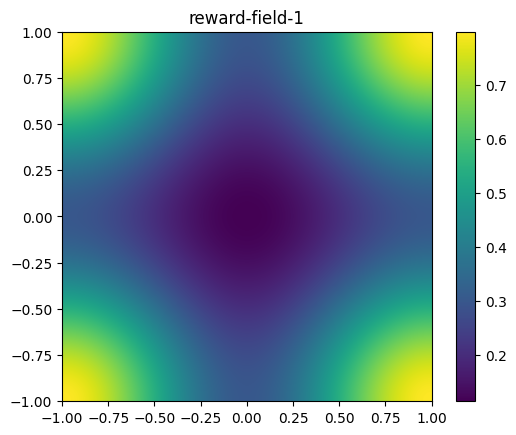

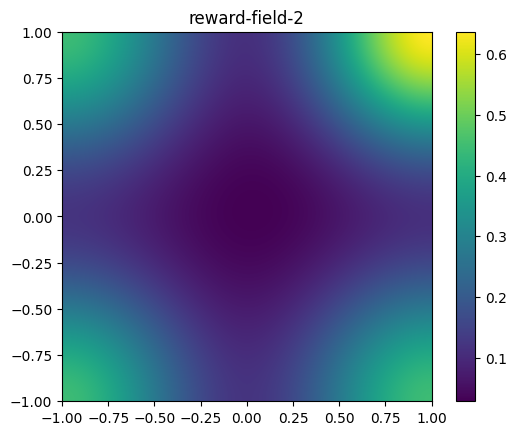

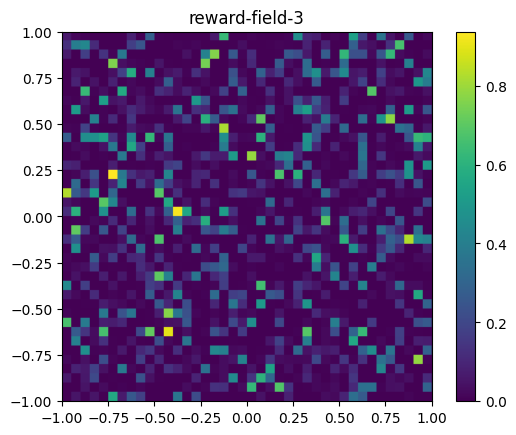

Tests passed.


<Figure size 640x480 with 0 Axes>

In [50]:
def visualize_fractal_problems():
  """Visualize the fractal problems with different rewards fields."""
  import matplotlib.pyplot as plt
  for name, problem in get_fractal_problems().items():
    plt.title(name)
    problem.visualize_reward_field(show=True)
    plt.clf()

visualize_fractal_problems()

print('Tests passed.')

## Path-cost Problem from Reward Problem


### Question
Implement the reduction from a reward problem to a path-cost problem **as in lecture**.

For reference, our solution is **31** line(s) of code.

In [72]:
def path_cost_problem_from_reward_problem(
    reward_problem: RewardProblem) -> PathCostProblem:
  """Reduce a reward maximization problem into a path search problem.

  You should take a close look that the class definition of `RewardProblem`,
  since they will be handy.
  Especially note that the horizon value is inclusive -- for a horizon value of $H$,
  the agent should be allowed to step exactly $H$ number of steps.

  Args:
    problem: a RewardProblem.

  Returns:
    A PathCostProblem
  """
  class MyPathCostProblem(PathCostProblem):
    def __init__(self, initial_state):
        super().__init__(initial_state)

    def step(self, state: State, action: Action):
      return (reward_problem.step(state[0],action),state[1]-1)

    def goal_test(self, state):
      if state[1] == 0:
        return True
      return False

    def step_cost(self, state1, action, state2):
      return reward_problem.rmax - reward_problem.reward(state1[0], action, state2[0])

    def actions(self, state):
       return reward_problem.actions(state[0])


  initial = (reward_problem.initial,reward_problem.horizon)
  return MyPathCostProblem(initial)


### Tests

In [73]:
def path_reward_reduction_test(path_cost_problem_from_reward_problem,
                               loc,
                               horizon: int = 4):
  problem = GradientRewardFieldProblem(locs=[loc],
                                       covs=0.3,
                                       strengths=[1.],
                                       horizon=horizon)
  path_problem = path_cost_problem_from_reward_problem(problem)
  state_sequence, action_sequence, cost_sequence, num_steps = run_uniform_cost_search(
      path_problem, step_budget=100000)
  assert ((len(state_sequence) - 1) == len(action_sequence) ==
          len(cost_sequence) == horizon)
  assert np.all(np.sign(np.array(action_sequence)) == np.sign(
      loc)), f"Actions {action_sequence} does not move towards {loc}"
  cost_sequence = np.array(cost_sequence)
  assert np.all(cost_sequence <= problem.rmax), "Costs should not exceed Rmax"
  assert np.all(cost_sequence >= 0), "Costs should be positive"
  assert np.all(np.diff(cost_sequence) <= 0), "Costs should be decreasing"

path_reward_reduction_test(path_cost_problem_from_reward_problem, (1, 1), 2)

def path_reward_reduction_test(path_cost_problem_from_reward_problem,
                               loc,
                               horizon: int = 4):
  problem = GradientRewardFieldProblem(locs=[loc],
                                       covs=0.3,
                                       strengths=[1.],
                                       horizon=horizon)
  path_problem = path_cost_problem_from_reward_problem(problem)
  state_sequence, action_sequence, cost_sequence, num_steps = run_uniform_cost_search(
      path_problem, step_budget=100000)
  assert ((len(state_sequence) - 1) == len(action_sequence) ==
          len(cost_sequence) == horizon)
  assert np.all(np.sign(np.array(action_sequence)) == np.sign(
      loc)), f"Actions {action_sequence} does not move towards {loc}"
  cost_sequence = np.array(cost_sequence)
  assert np.all(cost_sequence <= problem.rmax), "Costs should not exceed Rmax"
  assert np.all(cost_sequence >= 0), "Costs should be positive"
  assert np.all(np.diff(cost_sequence) <= 0), "Costs should be decreasing"

path_reward_reduction_test(path_cost_problem_from_reward_problem, (1, 1), 3)

def path_reward_reduction_test(path_cost_problem_from_reward_problem,
                               loc,
                               horizon: int = 4):
  problem = GradientRewardFieldProblem(locs=[loc],
                                       covs=0.3,
                                       strengths=[1.],
                                       horizon=horizon)
  path_problem = path_cost_problem_from_reward_problem(problem)
  state_sequence, action_sequence, cost_sequence, num_steps = run_uniform_cost_search(
      path_problem, step_budget=100000)
  assert ((len(state_sequence) - 1) == len(action_sequence) ==
          len(cost_sequence) == horizon)
  assert np.all(np.sign(np.array(action_sequence)) == np.sign(
      loc)), f"Actions {action_sequence} does not move towards {loc}"
  cost_sequence = np.array(cost_sequence)
  assert np.all(cost_sequence <= problem.rmax), "Costs should not exceed Rmax"
  assert np.all(cost_sequence >= 0), "Costs should be positive"
  assert np.all(np.diff(cost_sequence) <= 0), "Costs should be decreasing"

path_reward_reduction_test(path_cost_problem_from_reward_problem, (1, 1), 5)

def path_reward_reduction_test(path_cost_problem_from_reward_problem,
                               loc,
                               horizon: int = 4):
  problem = GradientRewardFieldProblem(locs=[loc],
                                       covs=0.3,
                                       strengths=[1.],
                                       horizon=horizon)
  path_problem = path_cost_problem_from_reward_problem(problem)
  state_sequence, action_sequence, cost_sequence, num_steps = run_uniform_cost_search(
      path_problem, step_budget=100000)
  assert ((len(state_sequence) - 1) == len(action_sequence) ==
          len(cost_sequence) == horizon)
  assert np.all(np.sign(np.array(action_sequence)) == np.sign(
      loc)), f"Actions {action_sequence} does not move towards {loc}"
  cost_sequence = np.array(cost_sequence)
  assert np.all(cost_sequence <= problem.rmax), "Costs should not exceed Rmax"
  assert np.all(cost_sequence >= 0), "Costs should be positive"
  assert np.all(np.diff(cost_sequence) <= 0), "Costs should be decreasing"

path_reward_reduction_test(path_cost_problem_from_reward_problem, (-1, -1), 2)

def path_reward_reduction_test(path_cost_problem_from_reward_problem,
                               loc,
                               horizon: int = 4):
  problem = GradientRewardFieldProblem(locs=[loc],
                                       covs=0.3,
                                       strengths=[1.],
                                       horizon=horizon)
  path_problem = path_cost_problem_from_reward_problem(problem)
  state_sequence, action_sequence, cost_sequence, num_steps = run_uniform_cost_search(
      path_problem, step_budget=100000)
  assert ((len(state_sequence) - 1) == len(action_sequence) ==
          len(cost_sequence) == horizon)
  assert np.all(np.sign(np.array(action_sequence)) == np.sign(
      loc)), f"Actions {action_sequence} does not move towards {loc}"
  cost_sequence = np.array(cost_sequence)
  assert np.all(cost_sequence <= problem.rmax), "Costs should not exceed Rmax"
  assert np.all(cost_sequence >= 0), "Costs should be positive"
  assert np.all(np.diff(cost_sequence) <= 0), "Costs should be decreasing"

path_reward_reduction_test(path_cost_problem_from_reward_problem, (-1, -1), 3)

def path_reward_reduction_test(path_cost_problem_from_reward_problem,
                               loc,
                               horizon: int = 4):
  problem = GradientRewardFieldProblem(locs=[loc],
                                       covs=0.3,
                                       strengths=[1.],
                                       horizon=horizon)
  path_problem = path_cost_problem_from_reward_problem(problem)
  state_sequence, action_sequence, cost_sequence, num_steps = run_uniform_cost_search(
      path_problem, step_budget=100000)
  assert ((len(state_sequence) - 1) == len(action_sequence) ==
          len(cost_sequence) == horizon)
  assert np.all(np.sign(np.array(action_sequence)) == np.sign(
      loc)), f"Actions {action_sequence} does not move towards {loc}"
  cost_sequence = np.array(cost_sequence)
  assert np.all(cost_sequence <= problem.rmax), "Costs should not exceed Rmax"
  assert np.all(cost_sequence >= 0), "Costs should be positive"
  assert np.all(np.diff(cost_sequence) <= 0), "Costs should be decreasing"

path_reward_reduction_test(path_cost_problem_from_reward_problem, (-1, -1), 5)
print('Tests passed.')

Tests passed.


## MCTS vs. UCS


### Utilities

Our implementation of MCTS.
**Note**: these imports and functions are available in catsoop. You do not need to copy them in.

In [ ]:

import dataclasses


@dataclasses.dataclass(frozen=False, eq=False)
class MCTNode:
  """Node in the Monte Carlo search tree, keeps track of the children states."""
  state: State
  U: float
  N: int
  horizon: int
  parent: Optional['MCTNode']
  children: Dict['MCTNode', Action] = dataclasses.field(default_factory=dict)


def ucb(n: MCTNode, C: float = 1.4) -> float:
  """UCB for a node, note the C argument"""
  return np.inf if n.N == 0 else (n.U / n.N +
                                  C * np.sqrt(np.log(n.parent.N) / n.N))


def run_mcts_search(problem: RewardProblem,
                    C: float = 1.4,
                    iteration_budget: int = 1000,
                    step_budget: int = np.inf):
  """A generic MCTS search implementation.

  Args:
    problem: a reward problem.
    C: the UCB parameter.
    iteration_budget: maximum iterations to run the search.
    step_budget: maximum number of allowed `problem.step`s.

  Returns:
    state_sequence: A list of states.
    action_sequence: A list of actions.
    reward_sequence: A list of rewards
  """
  if min(iteration_budget, step_budget) == np.inf:
    raise ValueError("Must provide at least one budget")

  problem_step_count = 0

  class BudgetExceeded(Exception):
    pass

  def step_helper(state, action):
    """helper to track the problem's step count."""
    nonlocal problem_step_count
    problem_step_count += 1
    if problem_step_count > step_budget:
      raise BudgetExceeded("step budget exceeded")
    return problem.step(state, action)

  ucb_fixed_C = functools.partial(ucb, C=C)

  def select(n: MCTNode) -> MCTNode:
    """select a leaf node in the tree"""
    if n.children:
      ucb_pick = max(n.children.keys(), key=ucb_fixed_C)
      return select(ucb_pick)
    return n

  def expand(n: MCTNode) -> MCTNode:
    """expand the leaf node by adding all its children states"""
    assert not n.children
    if n.horizon == 0:
      return n
    for action in problem.actions(n.state):
      child_state = step_helper(n.state, action)
      new_node = MCTNode(state=child_state,
                         horizon=n.horizon - 1,
                         parent=n,
                         U=0,
                         N=0)
      n.children[new_node] = action
    child = random.choice(list(n.children.keys()))
    return child

  def simulate(node: MCTNode) -> float:
    """simulate the utility of current state by randomly picking a step"""
    state = node.state
    total_reward = 0
    for h in range(node.horizon, 0, -1):
      action = random.choice(problem.actions(state))
      child_state = step_helper(state, action)
      reward = problem.reward(state, action, child_state)
      total_reward += reward
      state = child_state
    return total_reward

  def backup(n: MCTNode, value: float) -> None:
    """passing the utility back to all parent nodes"""
    if n.parent:
      # Need to include the reward on the action *into* n
      a = n.parent.children[n]
      r = problem.reward(n.parent.state, a, n.state)
      n.U += value + r
      n.N += 1
      backup(n.parent, value + r)
    else:
      n.N += 1

  root = MCTNode(state=problem.initial,
                 horizon=problem.horizon,
                 parent=None,
                 U=0,
                 N=0)

  try:
    i = 0
    while i < iteration_budget:
      leaf = select(root)
      child = expand(leaf)
      value = simulate(child)
      backup(child, value)
      i += 1
  except BudgetExceeded:
    pass

  return finish_mcts_plan(problem, root)


def finish_mcts_plan(problem: RewardProblem, node: MCTNode):
  """Helper for run_mcts_search. Recover the plan. """
  state_sequence = [node.state]
  action_sequence = []
  reward_sequence = []

  while node.children:
    max_node = max(node.children, key=lambda p: p.N)
    max_action = node.children.get(max_node)
    action_sequence.append(max_action)
    state_sequence.append(max_node.state)
    reward_sequence.append(
        problem.reward(node.state, max_action, max_node.state))
    node = max_node

  return state_sequence, action_sequence, reward_sequence

### Tests

In [ ]:
def visualize_mcts():
  """Solve one of the fractal problems and visualize the plan.

  This function may take a few moments to run.
  """
  # You may change this to visualize other reward fields.
  problem = get_fractal_problems()["reward-field-1"]

  plan = run_mcts_search(problem, iteration_budget=10000)
  problem.visualize_reward_field().visualize_plan(plan[0], show=True)

visualize_mcts()

print('Tests passed.')

### Compare the Performance

In [ ]:
problems = get_fractal_problems()
for name, problem in problems.items():
    # Run MCTS
    mcts_rewards = []
    for _ in range(20):
        plan = run_mcts_search(problem, iteration_budget=np.inf, step_budget=2500)
        mcts_rewards.append(sum(plan[2]))

    # Run UCS
    try:
        ucs_plan = run_uniform_cost_search(
            path_cost_problem_from_reward_problem(problem), step_budget=2500
        )
        ucs_reward = 0
        for r in ucs_plan[2]:
            ucs_reward += problem.rmax - r
        ucs_plan_length = len(ucs_plan[0]) - 1
    except SearchFailed:
        ucs_reward = 0
        ucs_plan_length = None

    print(f"Problem: {name}")
    print(f"MCTS Average Reward: {np.mean(mcts_rewards)}")
    print(f"UCS Reward: {ucs_reward}")
    print(f"UCS Steps: {ucs_plan_length}")